# Welcom to the tutorial to run Neural Network Calculation for Quantum Chemistry

In [1]:
from projects.NeuralForceField.train import *
from dbsetting import *
import numpy as np

# Get species, mostly silicate clusters

In [2]:
sps = Species.objects.filter(group__name='zeolite')

smiles_list = []

for sp in sps:
    if len(sp.smiles) < 40 and 'Si' in sp.smiles and 'C' not in sp.smiles:
        print(sp.smiles)
        smiles_list.append(sp.smiles)

O[Si](O)(O)O
O[Si](O)(O)O[Si](O)(O)O
O[Si](O)(O)O[Si](O)(O)O[Si](O)(O)O
O[Si]1(O)O[Si](O)(O)O[Si](O)(O)O1


In [3]:
geoms_id = list(Geom.objects.filter(species__smiles__in=smiles_list, method__name= 'dft_d3_gga_bp86').values_list("id", flat=True))

In [5]:
geoms = Geom.objects.filter(id__in=geoms_id)

In [6]:
values = get_xyz_force_energy_smiles(geoms, methodnames='dft_d3_gga_bp86')
xyz_data, force_data, energy_data, smiles_data = values

# Initialize Training and Network Parameters 

In [8]:
# initialize parameters
par = dict()
par["git_commit"] = ""
par["model_type"] = "schnet"   # model type, the other type is schnet_harmonic_bond_prior
par["n_filters"] = 256         # the filter dimensions 
par["n_gaussians"] = 32        # number of gaussian basis
par["n_atom_basis"] = 256      # dimension of atomic embeddings 
par["optim"] = 1e-4            # learning rate
par["scheduler"] = True        # use scheduler to dynamiclly change the learning rate 
par["train_percentage"] = 0.8  # percentage of data used for training 
par["T"] = 4                 # number of convolutions 
par["batch_size"] = 10       # batch size
par["cutoff"] = 5.0            # convolution radius
par["max_epoch"] = 1000        # max number of epoches training
par["trainable_gauss"] = True  # make the Gaussian parameter trainable 
par["rho"] = 0.1               # energy loss ratio
par["eps"] = 1e-5

device = 2 # which GPU to use

# Import Graph Builder and build a graph data set for training 

In [9]:
from projects.graphbuilder.graphbuilder import * 
from projects.NeuralForceField.graphs import * 

graph_data = load_graph_data(xyz_data=xyz_data, energy_data=energy_data, smiles_data=smiles_data,
                             batch_size=par["batch_size"], cutoff=par["cutoff"], 
                             force_data=force_data, au_flag=False)

Finished Batching 7 Batches


# Define Training wrappers, this steps also initializes a model and split train and test data randomly
# and start trainig for 10 epochs and look at validations 

setting up directoires for saving training files
epoch 0  U train: 7.041  force train 0.856
epoch 1  U train: 4.723  force train 0.768
epoch 2  U train: 3.596  force train 0.644
epoch 3  U train: 3.144  force train 0.493
epoch 4  U train: 2.085  force train 0.507
epoch 5  U train: 1.491  force train 0.335
epoch 6  U train: 1.454  force train 0.345
epoch 7  U train: 0.880  force train 0.256
epoch 8  U train: 0.728  force train 0.260
epoch 9  U train: 0.664  force train 0.202
epoch 10  U train: 0.464  force train 0.201
epoch 11  U train: 0.365  force train 0.172
epoch 12  U train: 0.311  force train 0.172
epoch 13  U train: 0.294  force train 0.153
epoch 14  U train: 0.175  force train 0.148
epoch 15  U train: 0.188  force train 0.139
epoch 16  U train: 0.179  force train 0.134
epoch 17  U train: 0.136  force train 0.128
epoch 18  U train: 0.132  force train 0.124
epoch 19  U train: 0.103  force train 0.121
epoch 20  U train: 0.102  force train 0.117
epoch 21  U train: 0.101  force train

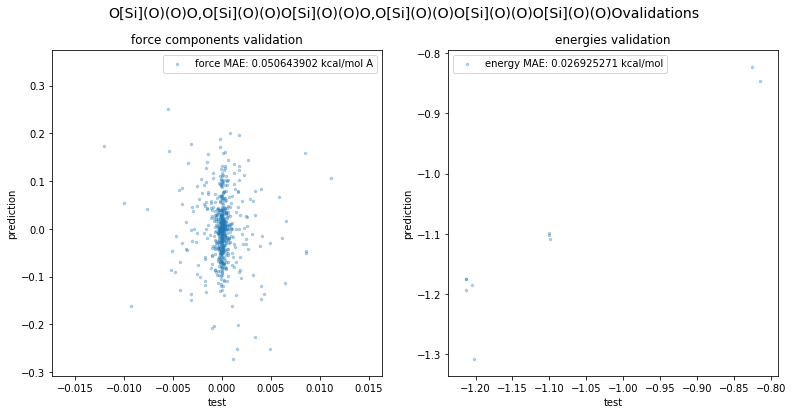

In [13]:
model = ModelPrior(par=par, graph_data=graph_data, device=device, job_name="zeolite",
              train_flag= True, graph_batching=True, root='./log/')

# Train for 10 epochs 
model.train(100)
model.validate()

# You can validate on the entire dataset too (that includes both training and testing)

forcesmae 0.053923562 kcal/mol A
energiesmae 0.027745787 kcal/mol


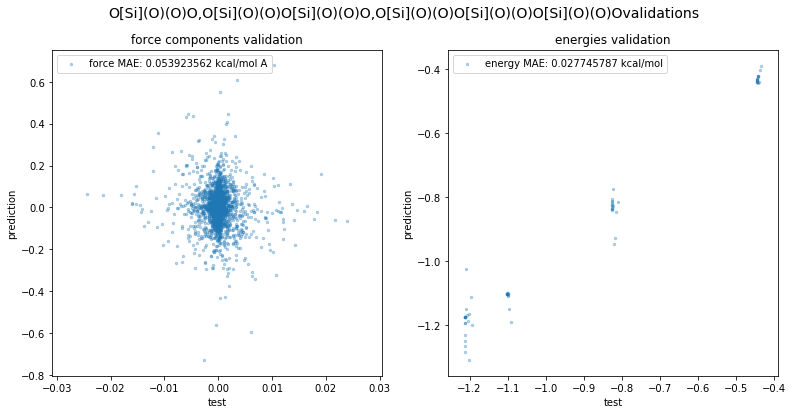

In [14]:
model.validate(graph_data)